In [1]:
##Author: Akif Erdem Sağtekin

##Implemented from "https://www.izhikevich.org/publications/spikes.htm"

from brian2 import *
from brian2tools import *
import numpy as np
np.random.seed(1337)

%matplotlib inline
defaultclock.dt = 0.5*ms 

# izhikevich model.

eqs = ''' dv/dt = (0.04/ms/mV)*v**2 + (5/ms)*v + 140*mV/ms - u/ms + I*mV/(amp*ms) : volt
          du/dt = a*(b*v - u)/ms  : volt
          I : amp
          a : 1
          b : 1
          c : volt
          d : volt '''

# synaptic parameters are fine-tuned in order to see the activity in the paper.
# in paper, they used -1*amp for inhibitory and 0.5*amp for excitatory.

we = 2*amp        # weights for excitatory synapses
wi = -4*amp       # weights for inhibitory synapses
EL = -65 * mV     # initial value of membrane potentials
dly = 0*ms        # delay

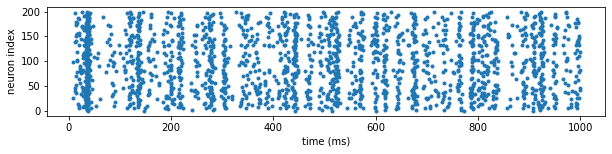

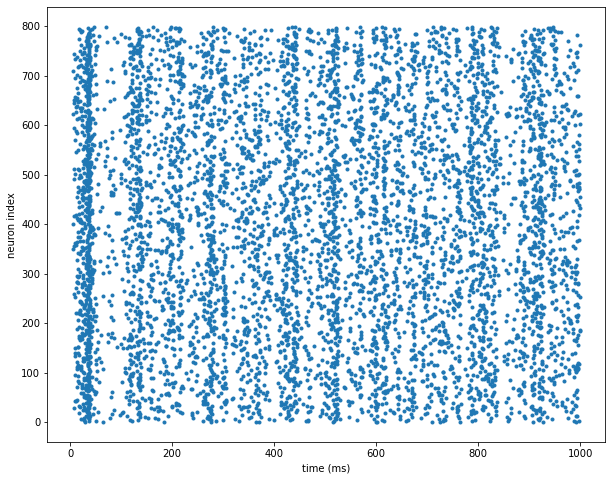

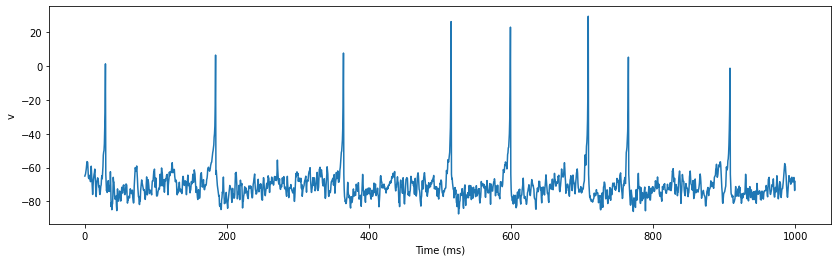

In [2]:
start_scope()

ex_num = 800
in_num = 200
total_num = ex_num + in_num

##define neuron groups
N_exc = NeuronGroup(ex_num, eqs, threshold='v>30*mV', reset='v=c; u+=d', method='euler')
N_inh = NeuronGroup(in_num, eqs, threshold='v>30*mV', reset='v=c; u+=d', method='euler')

##define state monitors
M_exc = StateMonitor(N_exc, ['v', 'u'], record=True)
M_inh = StateMonitor(N_inh, ['v', 'u'], record=True)

#define spike and rate monitors 
spikemon_exc = SpikeMonitor(N_exc)
ratemon_exc = PopulationRateMonitor(N_exc)

spikemon_inh = SpikeMonitor(N_inh)
ratemon_inh = PopulationRateMonitor(N_inh)

# regular spiking for excicatory neurons. gaussian "so-called-noise" is introduced for c and d parameters.
N_exc.a =0.02
N_exc.b =0.2
N_exc.c ='-65*mV + 15*mV*rand()**2'
N_exc.d = '(8 - 6*rand()**2)*mV'

# fast spikingin for inhibitory neurons. noise added to a and b parameters.
N_inh.a = '(0.02 + 0.08*rand())'
N_inh.b ='(0.25 - 0.05*rand())'
N_inh.c = -65*mV
N_inh.d = 2*mV

#defining synaptic connections. weights are randomized.

#from exc to exc.
Se1 = Synapses(N_exc, N_exc, 'w : amp', delay=dly, on_pre='I_post += w') # excitatory neurons' synapses
Se1.connect(p=1)
Se1.w = 'we*rand()' 

#from inh to exc.
Se2 = Synapses(N_inh, N_exc, 'w : amp', delay=dly, on_pre='I_post += w') # excitatory neurons' synapses
Se2.connect(p=1) 
Se2.w = 'wi*rand()'

#from exc to inh.
Si1 = Synapses(N_exc, N_inh, 'w : amp', delay=dly, on_pre='I_post += w') # inhibitory neurons' synapses
Si1.connect(p=1)
Si1.w = 'we*rand()'

#from inh to inh.
Si2 = Synapses(N_inh, N_inh, 'w : amp', delay=dly, on_pre='I_post += w') # inhibitory neurons' synapses
Si2.connect(p=1)
Si2.w = 'wi*rand()'

##initial values for exc and inh neurons.
N_exc.v = EL
N_exc.u = 'b*v'

N_inh.v = EL
N_inh.u = 'b*v'

##input. source: https://www.izhikevich.org/publications/spikes.htm
N_exc.run_regularly('I = 5*amp*randn()', dt=1*ms) 
N_inh.run_regularly('I = 2*amp*randn()', dt=1*ms)


run(1000*ms)



figure(figsize=(10, 2))
brian_plot(spikemon_inh)

figure(figsize=(10, 8))
brian_plot(spikemon_exc)

figure(figsize=(10, 4))
plot(M_exc.t/ms, M_exc.v[0]/mV)
ylabel('v')
xlabel('Time (ms)') 
show();
